# Regression Uncertainty
> "Learning uncertainty for regression using higher order distribution"

- toc: false
- branch: master
- badges: true
- comments: true
- image: images/nig_regression.png
- categories: [probability, regression, uncertainty]


## Regression

In machine learning problems we take input data $x$ and use it to predict the output data $y$. If the predicted data is continuous or discrete. When the output data $y$ is continuous then the problem is called **regression** while if its is discrete then the problem is called **classification** .

Deep neural networks have prooved to be a good tool for solving regression tasks. Currently there are new improvements in making the regression task robust by not only predicting the output data $y$ but also the corresponding uncertainty.

In this blog we will look into 2 methods of representing uncertatinty from literature.
1. Epistemic uncertatinty (Data uncertatinty) [1]
2. Aleotary uncertainty (Model uncertatinty)  [2]


![](https://github.com/deebuls/devblog/blob/master/_notebooks/images/nig_regression.png?raw=1)

### Hierarchical Modelling 

In regression task can be modelled in 3 different methods based on which all uncertainty needs to be accounted for during architecture of the deep network.
The different layers and their hierarchichal structre is represented in the image above. 

|Name| loss function | uncertatinty| output | distribution |
|---|---|---|---|---|
|Deterministic Regression| mean square error| not modeled| $\hat{y}$| - |
|Likelihood Regression | Maximum likelihood estimation | data| $\hat{y}$, $\sigma^2$| Normal |
|Evidential Regression | Maximum likelihood estimation | data + model| $\hat{y}$,$\alpha$, $\beta$, $\lambda$  | Normal inverse gamma|

In [1]:
#hide
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(1)    # reproducible

## Dataset 

We will start by creating a one dimension synthetic regression dataset.  The synthetic dataset has added *priori* noise.
The dataset is generated from 
$$ y =\frac{ \sin(3x)}{3x} + \epsilon $$ where $\epsilon \sim \mathcal{N}(0, 0.02)$

The training dataset consist of $x$ values between  $-3 \leq x \leq 3$; while the test dataset consist of values outside of training  $-4 \leq x \leq 4$

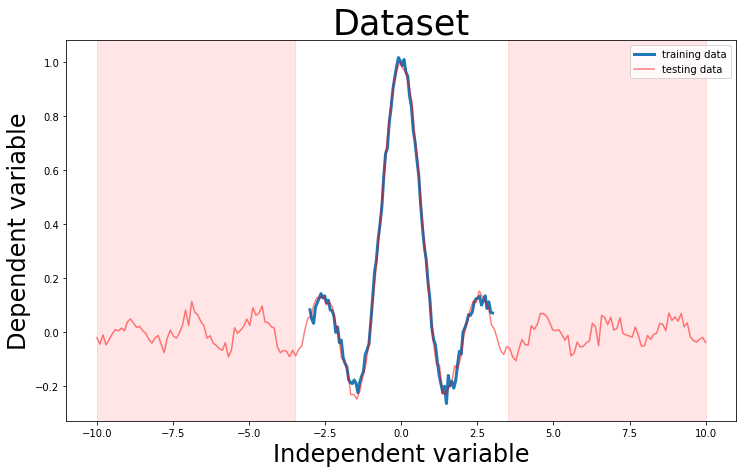

In [4]:
#hide_input
x_lim=[-10,10]; y_lim=[-1.25, 2.25]
x = torch.unsqueeze(torch.linspace(-3, 3, 100), dim=1)  # x data (tensor), shape=(100, 1)
test_x = torch.unsqueeze(torch.linspace(-10, 10, 200), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin( 3 * x) / (3 * x )+  torch.normal(0, 0.02,size=x.size())                 # noisy y data (tensor), shape=(100, 1)
test_y = (torch.sin( 3 * test_x) / (3 * test_x )) +  torch.normal(0, 0.02,size=test_x.size())                 # noisy y data (tensor), shape=(100, 1)
fig, ax = plt.subplots(figsize=(12,7))
plt.cla()
ax.set_title('Dataset', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.plot(x,y, linewidth=3, label='training data')
ax.plot(test_x, test_y, color='red', alpha=0.5, label='testing data')
ax.legend( )
ax.axvspan(x_lim[0], -3.5, alpha=0.1, color='red')
ax.axvspan(3.5, x_lim[1], alpha=0.1, color='red')
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
test_x, test_y = Variable(test_x), Variable(test_y)


In [0]:
#hide
def plot_prediction(x, y, prediction, sigma=0.01, e=0.01):
  x_lim=[-10,10]; y_lim=[-1.25, 2.25]
  p = prediction.view(-1).data.numpy()
  x = x.view(-1).data.numpy()
  y = y.view(-1).data.numpy()
  if not type(sigma) == float:
    sigma = sigma.view(-1).data.numpy()

  if not type(e) == float:
    e = e.view(-1).data.numpy()
    

  # plot and show learning process
  fig, ax = plt.subplots(figsize=(12,7))
  plt.cla()
  ax.set_title('Regression Analysis', fontsize=35)
  ax.set_xlabel('Independent variable', fontsize=24)
  ax.set_ylabel('Dependent variable', fontsize=24)
  ax.set_xlim(x_lim[0], x_lim[1])
  ax.set_ylim(y_lim[0], y_lim[1])
  ax.axvspan(x_lim[0], -3.5, alpha=0.1, color='blue')
  ax.axvspan(3.5, x_lim[1], alpha=0.1, color='blue')
  ax.scatter(x, y, color = "orange")
  ax.plot(x, p, 'g-', lw=3, alpha=0.8)
  
  ax.fill_between(x, p + 2*sigma,p - 2*sigma, color='gray', alpha=0.3)
  if not type(e) == float:
    ax.fill_between(x, p +e, p-e, color='gray', alpha=0.3)
  #ax.plot(x.data.numpy(), (prediction - 2*sigma).data.numpy(), 'gray', alpha=0.5)
  #ax.plot(x.data.numpy(), (prediction + 2*sigma).data.numpy(), 'gray', alpha=0.5)
  #ax.axvline(-3.5, alpha=0.5)
  
  #ax.axvline(3.5, alpha=0.5)
  ax.text(1.0, 0.5, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
  ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
          fontdict={'size': 24, 'color':  'red'})

## Model

We will be using a common model for all the different learning formulation.

In [0]:

# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
      
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden_2 = torch.nn.Linear(n_hidden, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(self.hidden_2(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


## Deterministic Regression

### Loss function 
Mean square error
$$ \mathcal{L} = \frac{1}{2} \vert \vert y_i - \hat{y} \vert \vert ^2$$

### Output
The model will have single output $\hat{y}$

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (hidden_2): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)
tensor(0.5153, grad_fn=<MseLossBackward>)
tensor(0.0478, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)


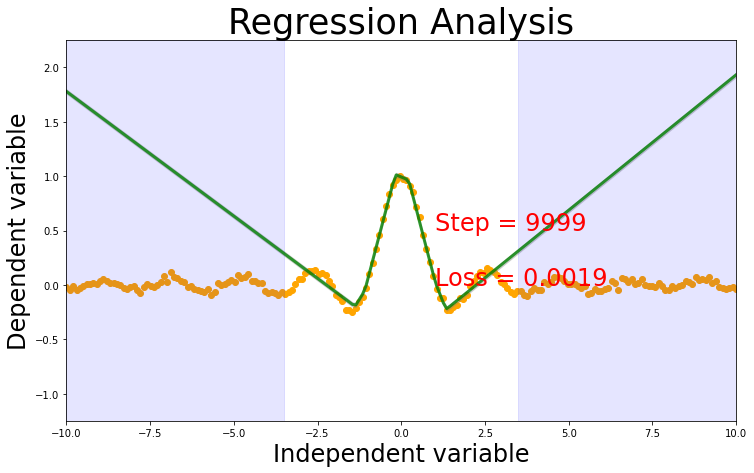

In [13]:


msenet = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(msenet)  # net architecture

#optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
optimizer = torch.optim.Adam(msenet.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


# train the network
for t in range(10000):
  
    prediction = msenet(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if t%1000 == 0: print(loss)

prediction = msenet(test_x)
plot_prediction(test_x, test_y, prediction)

## Likelihood Regression

### Loss function 
In here we will use the maximum likelihood estimation error, which is also called as the Negative log likelihood. 

$$ \mathcal{L} = -\left(-0.5\log(2\pi) - 0.5\sum\log(\sigma^2) - 0.5\sum\frac{(y - \hat{y})^2}{\sigma^2} \right) $$

### Output
We will create a deep net with 2 output variables. 
- predicted output $\hat{y}$ 
- the variance of the normal distribution $\sigma^2$

## Note
We aer also adding a regularizer $\frac{ \| y - \hat{y} \| }{ \sigma^2}$. This helps to regluarize the learning. It is inversely related to $\sigma^2$ and it scales based on distance from the actual value.

The regularizer ensures that values predicted far from true values have higher variance.So for values near to the predicted it gives less loss but values far away from prediction gives a large loss.

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (hidden_2): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=2, bias=True)
)
tensor(68.1900, grad_fn=<AddBackward0>)
tensor(6.4617, grad_fn=<AddBackward0>)
tensor(6.1683, grad_fn=<AddBackward0>)
tensor(6.1068, grad_fn=<AddBackward0>)
tensor(6.0325, grad_fn=<AddBackward0>)
tensor(5.9853, grad_fn=<AddBackward0>)
tensor(5.9657, grad_fn=<AddBackward0>)
tensor(5.9485, grad_fn=<AddBackward0>)
tensor(5.9929, grad_fn=<AddBackward0>)
tensor(5.9366, grad_fn=<AddBackward0>)


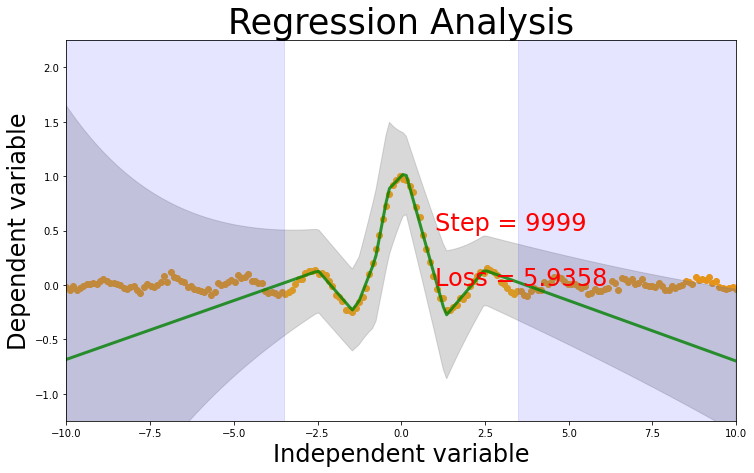

In [17]:
# Loss Function
class MLELoss(torch.nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(MLELoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):
    
    targets = targets.view(-1) #converting variable to single dimension

    mu = inputs[:,0].view(-1) #extracting mu and sigma_2
    logsigma_2 = inputs[:,1].view(-1) #logsigma and exp drives the variable to positive values always
    sigma_2 = torch.exp(logsigma_2)

    kl_divergence = (targets - mu)**2/sigma_2 #Regularizer 
    mse = -0.5 * torch.sum(((targets - mu)**2)/sigma_2)
    sigma_trace = -0.5  * torch.sum(sigma_2)
    log2pi = -0.5 *  np.log(2 * np.pi)
    J =  mse + sigma_trace + log2pi
 
    loss = -J + kl_divergence.sum()
    return loss


mlenet = Net(n_feature=1, n_hidden=10, n_output=2)     # define the network
print(mlenet)  # net architecture

optimizer = torch.optim.Adam(mlenet.parameters(), lr=0.001)
loss_func = MLELoss()  # this is for regression mean squared loss


# train the network
for t in range(10000):
  
    prediction = mlenet(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if t%1000 == 0: 
      print(loss)

prediction = mlenet(test_x)
mu = prediction[:,0]
sigma2 = torch.exp(prediction[:,1])
sigma = torch.sqrt(sigma2)
plot_prediction(test_x, test_y, mu, sigma)


## Evidential Regression

Evidential regression is based on paper [2] (Amini & e.t.al, 2019), which is based on the ideas of [3, 4] that if we represent the output of the model with a higher order data distribution its possible to model the data and model uncertainties.

### Loss

$$ \mathcal{L} = \left( \frac{ \Gamma(\alpha - 0.5)}{4\Gamma(\alpha)\lambda\sqrt\beta} \right) \left( 2\beta(1 + \lambda) + (2\alpha -1)\lambda(y_i - \hat{y})^2 \right)$$

### output

The model has 4 outputs
- $\hat{y}$
- $\alpha$
- $\beta$
- $\lambda$

### Regularizer

Regularizer is required  to penalize the loss function for OOD predictions.

$$ \| y - \hat{y}\| ^2 (2 \alpha + \lambda)$$

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (hidden_2): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=4, bias=True)
)
tensor(3.1019, grad_fn=<MeanBackward0>)
tensor(0.1492, grad_fn=<MeanBackward0>)


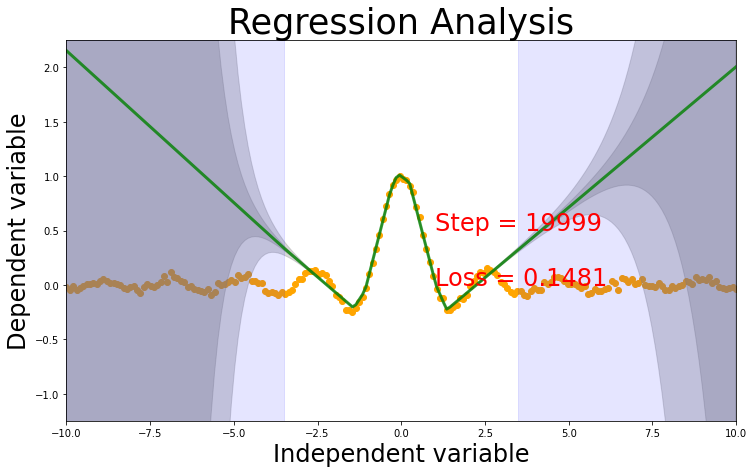

In [25]:
class EvidentialLoss(torch.nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(EvidentialLoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):
    targets = targets.view(-1)
    y = inputs[:,0].view(-1) #first column is mu,delta, predicted value
    loga = inputs[:,1].view(-1) #alpha
    logb = inputs[:,2].view(-1) #beta
    logl = inputs[:,3].view(-1) #lamda

    a = torch.exp(loga)
    b = torch.exp(logb)
    l = torch.exp(logl)


    term1 = (torch.exp(torch.lgamma(a - 0.5)))/(4 * torch.exp(torch.lgamma(a)) * l * torch.sqrt(b))
    #print("term1 :", term1)
    term2 = 2 * b *(1 + l) + (2*a - 1)*l*(y - targets)**2
    #print("term2 :", term2)

    J = term1 * term2
    #print("J :", J)
    Kl_divergence = torch.abs(y - targets) * (2*a + l)
    #Kl_divergence = ((y - targets)**2) * (2*a + l)
    
    #print ("KL ",Kl_divergence.data.numpy())
    loss = J + Kl_divergence

    #print ("loss :", loss)

    return loss.mean()

evnet = Net(n_feature=1, n_hidden=10, n_output=4)     # define the network
print(evnet)  # net architecture

optimizer = torch.optim.Adam(evnet.parameters(), lr=0.001)
loss_func = EvidentialLoss() 


# train the network
for t in range(20000):
  
    prediction = evnet(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t%10000 == 0: print(loss)



prediction = evnet(test_x)
mu = prediction[:,0].view(-1) #first column is mu,delta, predicted value
a = prediction[:,1].view(-1) #alpha
b = prediction[:,2].view(-1) #beta
l = prediction[:,3].view(-1) #lamda

a = torch.exp(a); b = torch.exp(b); l = torch.exp(l)
var = b / ((a -1)*l) #epistemic/ model/prediciton uncertaitnty
e = b / (a - 1) # aleatoric uncertainty/ data uncertainty
plot_prediction(test_x, test_y, mu, var, e)


## Conclusions

- Loss functions of maximum likelihood and evidence have been implemented from formulas from the paper.
> Important: Leasons Learned 
> how to treat loss function when one of the output variable is always positive. (log and exponential to rescue)
> The difference between optimize and loss function and do you sum and add constant ones or do you add constant in all equation and sum.

- The trianing is working on some runs not all.
- The model learns the function easily but learning the uncertainty in unkonw region takes longer number of iterations. Needs to be further investigated.


> Note ToDo : Test functions for the loss function written
> Note ToDo : What is stopping condition? when to stop learning?
> Note ToDo : Replace the regularizer in regularizer in likelihood loss with actual regularizer.
> Warning Why is uncertatiny different for both the models. Evidential model seems to be very confident in the known region, which seems to be fishy
> Warning The loss function doesnt give same results all the time, so needs to be further investigated


## References

[1] Kendall, Alex, and Yarin Gal. “What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?” ArXiv:1703.04977 [Cs], October 5, 2017. http://arxiv.org/abs/1703.04977.

[2] Amini, Alexander, Wilko Schwarting, Ava Soleimany, and Daniela Rus. “Deep Evidential Regression.” ArXiv:1910.02600 [Cs, Stat], October 7, 2019. http://arxiv.org/abs/1910.02600.

[3] Sensoy, Murat, Lance Kaplan, and Melih Kandemir. “Evidential Deep Learning to Quantify Classification Uncertainty,” n.d., 11.

[4]  Malinin, Andrey, and Mark Gales. "Predictive uncertainty estimation via prior networks." Advances in Neural Information Processing Systems. 2018.
